<a href="https://colab.research.google.com/github/hkaragah/risk_reliability/blob/main/Gutenberg_Richter_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gutenberg-Richter Distribution

## 1. Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import pandas as pd

## 2. Gutenberg-Richter Distribution

The modern equivalent of the Gutenberg-Richter (GR) distribution is a boubly-bounded exponential distribution with the PDF function defined as:

$$
f_M(m) =
\begin{cases}
0, &&m<m_{min} \ \ \text{and} \ \ m>m_{max}\\
\\
\cfrac{\beta e^{-\beta (m - m_{min})}}{1-e^{-\beta (m_{max}-m_{min})}}, &&m_{min} \leq m \leq m_{max}
\end{cases}$$

and the CDF is defined as:

$$
F_M(m) =
\begin{cases}
0, &&m<m_{min}\\
\\
\cfrac{1-e^{-\beta(m - m_{min})}}{1-e^{-\beta(m_{max}-m_{min})}}, &&m_{min} \leq m \leq m_{max}\\
\\
1, &&m>m_{max}
\end{cases}$$



In [ ]:
class Gutenberg_Richter(object):
    def __init__(self, m_min:float, m_max:float, b:float, resolution=10):
        self.m_min = m_min
        self.m_max = m_max
        self.b = b
        self.beta = log(10) * b
        self.resolution = resolution
        self.step = (m_max - m_min) / resolution
        self.m = np.arange(m_min + self.step/2, m_max - self.step/2, self.step)

    def pdf(self, **kwargs):
        m = kwargs.get('m', self.m)
        return self.beta * np.exp(-self.beta * (m - self.m_min)) / (1 - np.exp(-self.beta * (self.m_max - self.m_min)))

    def cdf(self, **kwargs):
        m = kwargs.get('m', self.m)
        return (1 - np.exp(-self.beta * (m - self.m_min))) / (1 - np.exp(-self.beta * (self.m_max - self.m_min)))

    def plot_pdf(self, figsize=(5,4)):
        self._plot(self.m, self.pdf(), 'Magnitude', 'Probability Distribution Function (PDF)', figsize)

    def plot_cdf(self, figsize=(5,4)):
        self._plot(self.m, self.cdf(), 'Magnitude', 'Cumulative Distribution Function (CDF)', figsize)

    def proba_of_occurrence(self) -> np.ndarray:
        return self.cdf(m = self.m + self.step/2) - self.cdf(m = self.m - self.step/2)

    def rate_of_occurrence(self, activity_rate) -> np.ndarray:
        return activity_rate * self.proba_of_occurrence()

    def rate_of_exceedance(self, activity_rate) -> np.ndarray:
        return np.flipud(np.flipud(self.rate_of_occurrence(activity_rate)).cumsum())

    def _plot(self, x, y, xlabel, ylabel, figsize):
        plt.figure(figsize=figsize)
        sns.lineplot(x=x, y=y)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.show()

In [ ]:
m_min, m_max, b, resolution = 5, 8, 1, 15

gr = Gutenberg_Richter(m_min, m_max, b, resolution)

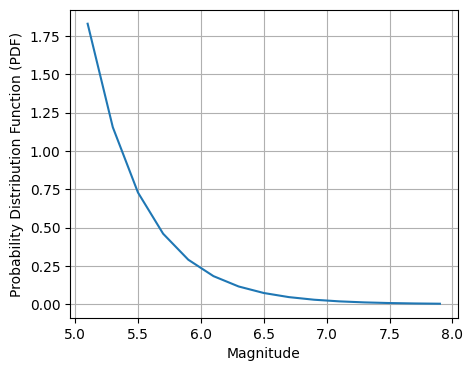

In [ ]:
gr.plot_pdf()

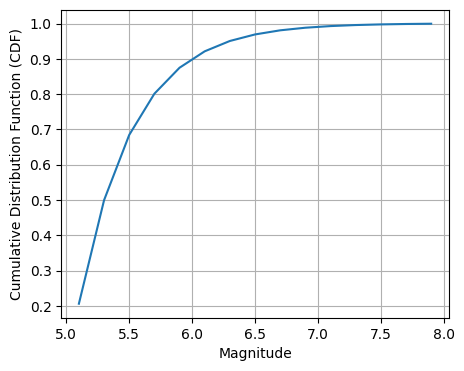

In [ ]:
gr.plot_cdf()

## 3. Rate of Exceedance

In [ ]:
activity_rate = 0.05

gr_df = pd.DataFrame(data={
    'm':gr.m,
    'pdf':gr.pdf(),
    'cdf':gr.cdf(),
    'proba_of_occurence':gr.proba_of_occurrence(),
    'rate_of_occurence': gr.rate_of_occurrence(activity_rate),
    'rate_of_exceedance': gr.rate_of_exceedance(activity_rate)})

gr_df.head()

,m,pdf,cdf,proba_of_occurence,rate_of_occurence,rate_of_exceedance
0,5.1,1.830839,0.205878,0.369412,0.018471,0.050000
1,5.3,1.155181,0.499312,0.233083,0.011654,0.031529
2,5.5,0.728870,0.684457,0.147066,0.007353,0.019875
3,5.7,0.459886,0.801275,0.092792,0.004640,0.012522
4,5.9,0.290168,0.874982,0.058548,0.002927,0.007882


In [ ]:
def plot_rate_of_exceedance(gr_list:list[gutenberg_richter], activity_rates:list, figsize:tuple=(5,4)):
    plt.figure(figsize=figsize)
    for activity_rate in activity_rates:
      for gr in gr_list:
        sns.lineplot(x=gr.m, y=gr.rate_of_exceedance(activity_rate), label=fr'$M_{{max}}={gr.m_max}, b={gr.b}, \lambda={activity_rate}$')
    plt.yscale('log')
    plt.xlim(min([gr.m_min for gr in gr_list]), max([gr.m_max for gr in gr_list]))
    plt.ylim(1e-6, 1e-1)
    plt.xlabel('Magnitude, M')
    plt.ylabel(r'Rate of Exceedance, $\lambda (M \geq m)$')
    plt.title(fr'Gutenberg-Richter Distribution [$M_{{min}}={min([gr.m_min for gr in gr_list])}$]', fontsize=10)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

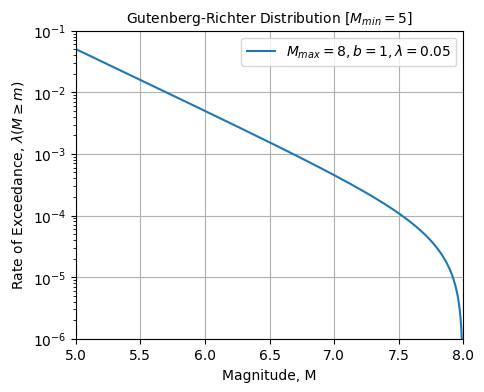

In [ ]:
resolution = 500
gr = gutenberg_richter(m_min, m_max, b, resolution)

plot_rate_of_exceedance([gr], [0.05])

## 4. Sensitivity Analysis: $b$

In [ ]:
m_min, m_max, resolution = 5, 8, 500

gr_list = []
for b in [0.9, 1.0, 1.1]:
    gr_list.append(gutenberg_richter(m_min, m_max, b, resolution))

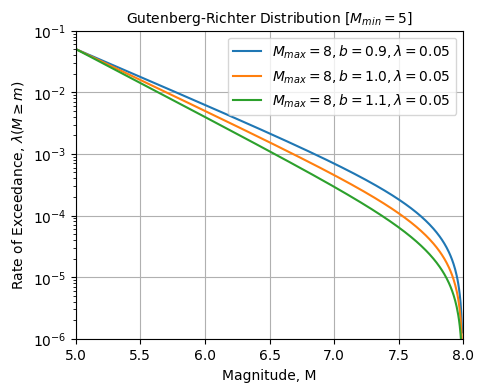

In [ ]:
plot_rate_of_exceedance(gr_list, activity_rates=[0.05])

## 5. Sensetivity Analysis: $M_{max}$

In [ ]:
m_min, b, resolution = 5, 1, 500

gr_list = []
for m_max in [7.6, 7.8, 8.0]:
    gr_list.append(gutenberg_richter(m_min, m_max, b, resolution=500))

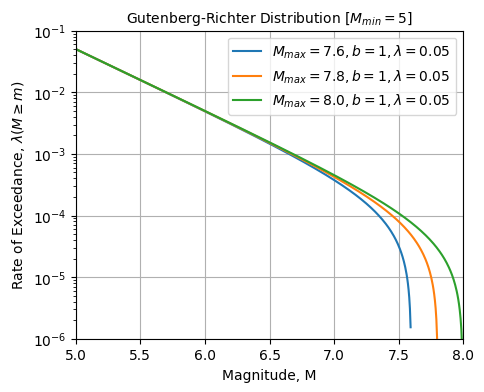

In [ ]:
plot_rate_of_exceedance(gr_list, activity_rates=[0.05])

## 6. Sensitivity Analysis: $\lambda$ (activity rate)

In [ ]:
m_min, m_max, b, resolution = 5, 8, 1, 500

gr_list = [gutenberg_richter(m_min, m_max, b, resolution=500)]

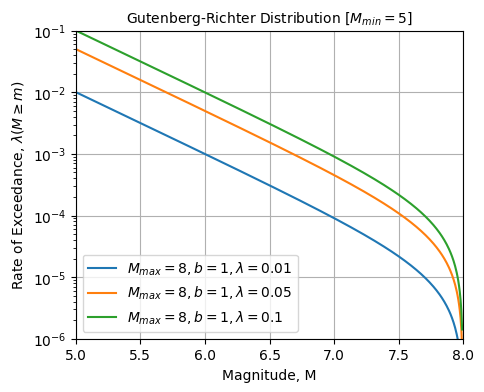

In [ ]:
plot_rate_of_exceedance(gr_list, activity_rates=[0.01, 0.05, 0.1])